Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(42000, 784)
(28000, 784)
8


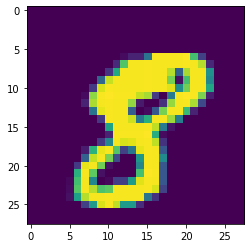

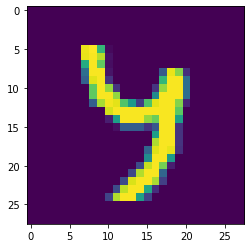

In [84]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
%matplotlib inline 
from matplotlib import pyplot as plt


from google.colab import drive
drive.mount('/content/drive')

dt_train_path = "drive/MyDrive/Kaggle_digits/train.csv"
dt_test_path = "drive/MyDrive/Kaggle_digits/test.csv"

# open CSV with pandas, then convert to numpy and splice into data and labels
dt_train_1d = pd.read_csv(dt_train_path).values
dt_train = dt_train_1d[:, 1:]
dt_train_labels = dt_train_1d[:, 0]

# no labels in test data.
dt_test = pd.read_csv(dt_test_path).values

print(dt_train.shape)
print(dt_test.shape)

# convert 784 into 28x28
dt_train = np.reshape(dt_train, (dt_train.shape[0], 28, 28))
dt_test = np.reshape(dt_test, (dt_test.shape[0], 28, 28))

print(dt_train_labels[10])
plt.imshow(dt_train[10])
plt.show()
plt.imshow(dt_test[12])
plt.show()



In [100]:
# out = ((n + 2p - k)/s) + 1
# 
class MyModel(torch.nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = nn.Sequential(
      nn.Conv2d(1, 8, 3, 1, 1), #28->28
      nn.ReLU(),
      nn.MaxPool2d(2, 2)
      # nn.BatchNorm2d(8)) #28->14
    self.conv2 = nn.Sequential(
        nn.Conv2d(8, 16, 3, 1, 1),           #14->14
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
        # nn.BatchNorm2d(16)) #14->7
    self.conv3 = nn.Sequential(
        nn.Conv2d(16, 32, 3, 1, 1), #7->7
        nn.ReLU()
        # nn.BatchNorm2d(32)
    )
    self.flatten = nn.Flatten()
    self.fc1 = nn.Sequential(
        nn.Linear(7*7*32, 728),
        nn.Sigmoid())
    self.fc2 = nn.Sequential(
        nn.Linear(728, 10),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return x



SyntaxError: ignored

In [101]:
tensor_train = torch.Tensor(dt_train)
tensor_train = tensor_train.unsqueeze(1)
tensor_test = torch.Tensor(dt_test)
tensor_test = tensor_test.unsqueeze(1)
tensor_train_labels = torch.Tensor(dt_train_labels)


train_dataset = TensorDataset(tensor_train, tensor_train_labels)
train_dataset, eval_dataset = torch.utils.data.random_split(train_dataset, [int(0.8*len(train_dataset)), int(0.2*len(train_dataset))])
data_loader_train = DataLoader(train_dataset, batch_size=1024)

# one, two = eval_dataset[:]
# print(one)

In [104]:
model = MyModel()

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

print(model)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

MyModel(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Sequential(
    (0): Linear(in_features=1568, out_features=728, bias=True)
    (1): Sigmoid()
  )
  (fc2): Sequential(
    (0): Linear(in_features=728,

In [105]:

num_epochs = 20
for epoch in range(num_epochs):
  epoch_loss = 0
  epoch_accuracy_train = 0
  model.train()
  for i, (images, labels) in enumerate(data_loader_train):
    out = model(images)
    loss = loss_function(out, labels.long())
    epoch_loss += loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total = labels.size(0)
    _, pred = torch.max(out.data, 1)
    correct = (pred == labels).sum().item()
    epoch_accuracy_train += correct/total

  model.eval()
  x_eval, y_eval = eval_dataset[:]
  out = model(x_eval)
  _, pred = torch.max(out.data, 1)
  correct = (pred == y_eval).sum().item()

  print("loss: {}".format(epoch_loss/len(data_loader_train)))
  print("train acc: {}".format(epoch_accuracy_train/len(data_loader_train)))
  print("eval acc: {} \n".format(correct/len(y_eval)))
  
  if (correct/len(y_eval) >= 0.99):
    break

loss: 1.7256783246994019
train acc: 0.8579158471736597
eval acc: 0.9536904761904762 

loss: 1.5169925689697266
train acc: 0.9644863599941725
eval acc: 0.9727380952380953 

loss: 1.4927674531936646
train acc: 0.9779852309149184
eval acc: 0.9797619047619047 

loss: 1.483755111694336
train acc: 0.9842111013986015
eval acc: 0.9821428571428571 

loss: 1.4785819053649902
train acc: 0.9878487398018648
eval acc: 0.9827380952380952 

loss: 1.475162148475647
train acc: 0.9902229931526806
eval acc: 0.9829761904761904 

loss: 1.4727106094360352
train acc: 0.9917982408216783
eval acc: 0.9832142857142857 

loss: 1.4708360433578491
train acc: 0.9932255244755245
eval acc: 0.9840476190476191 

loss: 1.4693888425827026
train acc: 0.9945116732226107
eval acc: 0.9853571428571428 

loss: 1.4682420492172241
train acc: 0.9953766936188813
eval acc: 0.9861904761904762 

loss: 1.4673043489456177
train acc: 0.9962052921037297
eval acc: 0.9872619047619048 

loss: 1.466511607170105
train acc: 0.9968563337703964
ev

KeyboardInterrupt: ignored

In [ ]:
model.eval()
out = model(tensor_test)
_, pred = torch.max(out.data, 1)
print(pred.numpy().shape)

submission = pd.read_csv("drive/MyDrive/Kaggle_digits/sample_submission.csv")
submission['Label'] = pred
submission.to_csv("drive/MyDrive/Kaggle_digits/to_submit2.csv", index=False)
